#6 Steps to Final Output

1.   Import Libraries
2.   Send Get Request to Wikipedia Page and Save Response
3.   Create a Pandas DataFrame and Shape it
4.   Print the Number of Rows and Columns in the DataFrame
5.   Add Latitude and Longitude Columns to the DateFrame
6.   Visualise Clusters on a Map


###1. Import Libraries

In [0]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import folium
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

###2. Send GET Request to Wikipedia Page and Save Response

*   Send GET request
*   Save response to BeautifulSoup object
*   Find Table content and save it in a variable

In [0]:
res = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

if res.status_code == 200:
  bs = BeautifulSoup(res.text, 'html.parser')
  table_contents = bs.find('table', class_="wikitable sortable")
else:
  print("Requests Error: status was {}.".format(res.status_code))

###3. Create Pandas DataFrame and Shape it

*   Find values for column names and save them to list
*   Find values for each column and save them to list
*   Create new Pandas DataFrame
*   Shape the DataFrame

In [3]:
column_list = [column.get_text().replace('\n', '') for column in table_contents.find_all('th')]

item_list = [item.get_text().replace('\n', '') for item in table_contents.find_all('td')]
length = len(item_list)
item_list_split = [item_list[index:index + 3] for index in range(0, length, 3)]

df = pd.DataFrame(item_list_split, columns=column_list)
df = df[df['Borough'] != 'Not assigned'].sort_values(['Postal Code', 'Borough'])
df = df.reset_index(drop=True)
df

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


###4. Print the Number of Rows and Columns in the DataFrame

In [4]:
shape = df.shape
print('There are {} rows and {} columns in the dataframe.'.format(shape[0], shape[1]))

There are 103 rows and 3 columns in the dataframe.


###5. Add Latitude and Longitude Columns to the DataFrame

*   Create new DataFrame from CSV file
*   Join DataFrame (key=Postal Code)



In [5]:
geo_df = pd.read_csv('https://cocl.us/Geospatial_data')
df = pd.merge(df, geo_df, on='Postal Code', how='left')
df

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


### 6. Visualise Clusters on a Map

*   Try to find the best k
*   Add cluster labels to DataFrame
*   Create an initial map by folium
*   Place markers on toronto map for quick sight of clusters



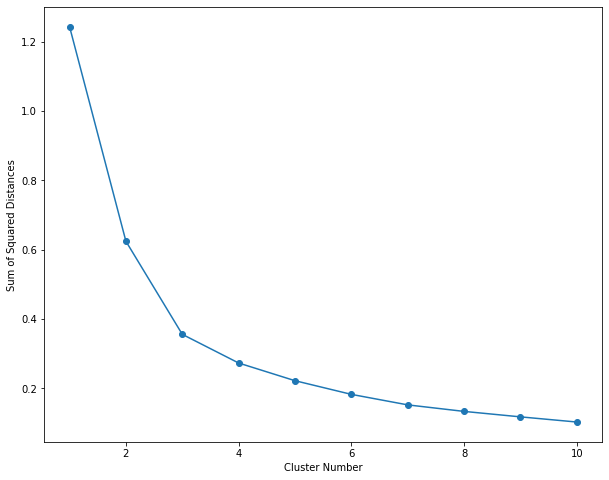

In [6]:
coodinate_list = df[['Latitude', 'Longitude']]

inertia_list = []

for k in range(1,11):
  kmeans = KMeans(n_clusters=k, random_state=0)
  kmeans.fit(coodinate_list)
  inertia_list.append(kmeans.inertia_)

plt.rcParams['figure.figsize'] = (10, 8)
plt.plot([i for i in range(1,11)], inertia_list, marker='o')
plt.xlabel('Cluster Number')
plt.ylabel('Sum of Squared Distances')
plt.show()

In [7]:
k = 7
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(coodinate_list)
cluster_labels = kmeans.labels_

output_df = df.assign(Cluster_Number=cluster_labels)
output_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster_Number
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,2
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,2
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,2
3,M1G,Scarborough,Woburn,43.770992,-79.216917,2
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,2


In [8]:
temp_lat = df['Latitude'].iloc[0]
temp_lon = df['Longitude'].iloc[0]

toronto_map = folium.Map(location=[temp_lat, temp_lon], zoom_start=11)

color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_list = color_list[0:k]

for row in output_df.itertuples():
  index = row[0]
  cluster_num = row[6]
  neighborhood = row[3]
  lat = row[4]
  lon = row[5]
  
  folium.CircleMarker(location=[lat, lon], 
                      popup=neighborhood,
                      tooltip='Click for detail',
                      radius=10,
                      color=color_list[cluster_num-1],
                      fill=True,
                      fill_color=color_list[cluster_num-1]).add_to(toronto_map)

toronto_map